In [58]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools

from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues
from bold_dementia.utils.iterables import unique

ATLAS = "msdl"
SOFT = True
ALPHA = config["alpha"]

In [59]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
coords = atlas.get_coords()

In [75]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}_TIV"
)
print(f"Loading matrices from {matrices_path}")
#AD_matrices = joblib.load(matrices_path / "AD.joblib")
#control_matrices = joblib.load(matrices_path / "control.joblib")
fdrmat = joblib.load(matrices_path / "pmat.joblib")
tstats = joblib.load(matrices_path / "statmap.joblib")

#n_AD = AD_matrices.shape[0]
#n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

Loading matrices from /homes_unix/jlegrand/data/Memento/output/connectivity/atlas-msdl_TIV


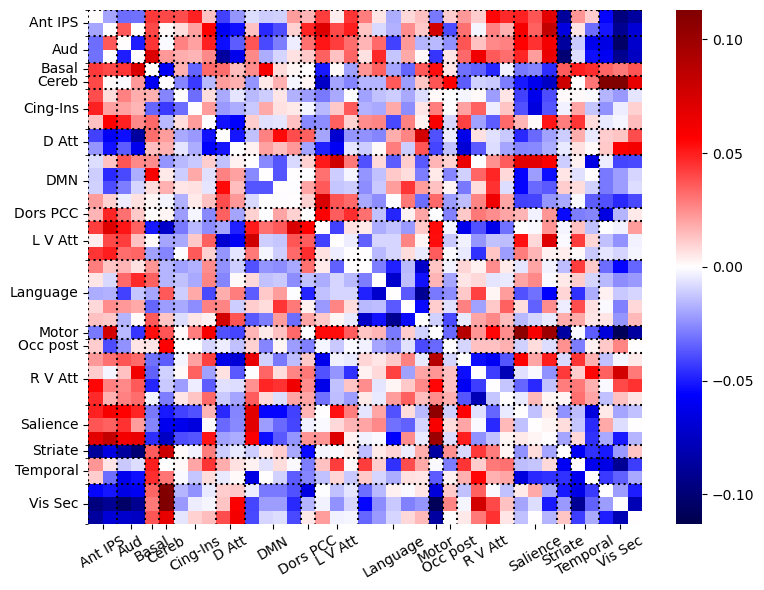

In [76]:
from bold_dementia.connectivity import plot_ordered_matrix

plot_matrix(tstats, atlas)
plt.show()

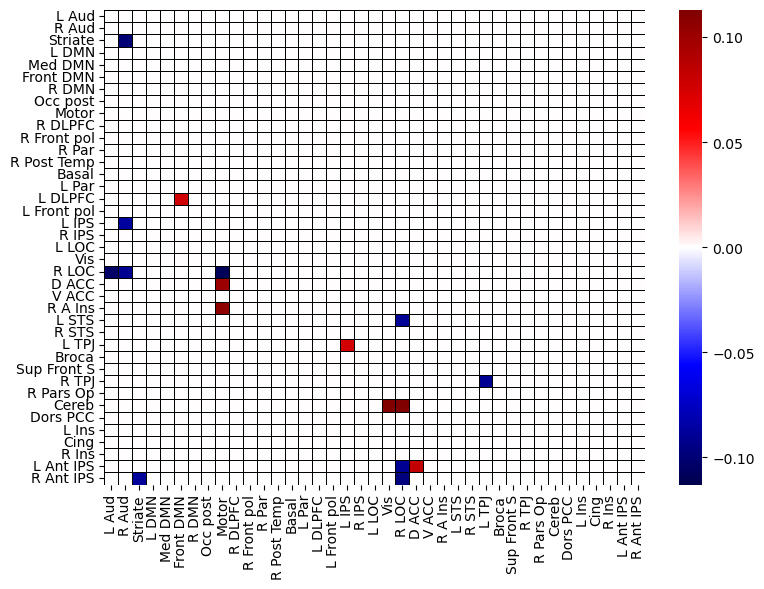

In [77]:

thresholded_t = tstats * np.where(fdrmat < 0.05, 1, 0)

plot_ordered_matrix(np.triu(thresholded_t).T, atlas)
plt.show()

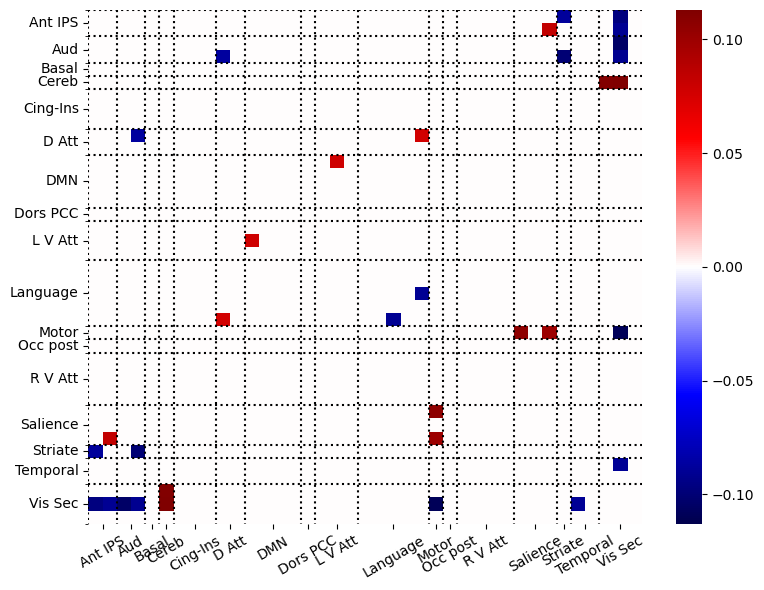

In [78]:
plot_matrix(thresholded_t, atlas)
plt.show()

In [79]:
ticks, sort_index = group_by_networks(atlas.macro_labels)
block_mat = thresholded_t[np.ix_(sort_index, sort_index)]
ticks

Ant IPS
Aud
Basal
Cereb
Cing-Ins
D Att
DMN
Dors PCC
L V Att
Language
Motor
Occ post
R V Att
Salience
Striate
Temporal
Vis Sec


[0, 2, 4, 5, 6, 9, 11, 15, 16, 19, 24, 25, 26, 30, 33, 34, 36, 39]

In [80]:
dict(zip(atlas.labels, atlas.macro_labels))

{'L Aud': 'Aud',
 'R Aud': 'Aud',
 'Striate': 'Striate',
 'L DMN': 'DMN',
 'Med DMN': 'DMN',
 'Front DMN': 'DMN',
 'R DMN': 'DMN',
 'Occ post': 'Occ post',
 'Motor': 'Motor',
 'R DLPFC': 'R V Att',
 'R Front pol': 'R V Att',
 'R Par': 'R V Att',
 'R Post Temp': 'R V Att',
 'Basal': 'Basal',
 'L Par': 'L V Att',
 'L DLPFC': 'L V Att',
 'L Front pol': 'L V Att',
 'L IPS': 'D Att',
 'R IPS': 'D Att',
 'L LOC': 'Vis Sec',
 'Vis': 'Vis Sec',
 'R LOC': 'Vis Sec',
 'D ACC': 'Salience',
 'V ACC': 'Salience',
 'R A Ins': 'Salience',
 'L STS': 'Temporal',
 'R STS': 'Temporal',
 'L TPJ': 'Language',
 'Broca': 'Language',
 'Sup Front S': 'Language',
 'R TPJ': 'Language',
 'R Pars Op': 'Language',
 'Cereb': 'Cereb',
 'Dors PCC': 'Dors PCC',
 'L Ins': 'Cing-Ins',
 'Cing': 'Cing-Ins',
 'R Ins': 'Cing-Ins',
 'L Ant IPS': 'Ant IPS',
 'R Ant IPS': 'Ant IPS'}

In [81]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))
network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

Ant IPS       (0, 2)
Aud           (2, 4)
Basal         (4, 5)
Cereb         (5, 6)
Cing-Ins      (6, 9)
D Att        (9, 11)
DMN         (11, 15)
Dors PCC    (15, 16)
L V Att     (16, 19)
Language    (19, 24)
Motor       (24, 25)
Occ post    (25, 26)
R V Att     (26, 30)
Salience    (30, 33)
Striate     (33, 34)
Temporal    (34, 36)
Vis Sec     (36, 39)
dtype: object

In [82]:
from itertools import product
def block_block(matrix, network_to_idx):
    for network_a, network_b in product(network_to_idx.index, network_to_idx.index):
            loc_a, loc_b = network_to_idx[network_a], network_to_idx[network_b]
            block = matrix[loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]]
            n_positive_edges = np.count_nonzero(block > 0)
            n_negative_edges = np.count_nonzero(block < 0)
            
            block_size = (loc_a[1] - loc_a[0]) * (loc_b[1] - loc_b[0])
            block_activation = (n_negative_edges + n_negative_edges) / block_size

            yield network_a, network_b, n_positive_edges, n_negative_edges, block_activation
        

In [83]:
gen = block_block(block_mat, network_to_idx)
comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "npos", "nneg", "activation"])

In [84]:
comparisons_pv = comparisons.pivot(index="node_a", columns="node_b")

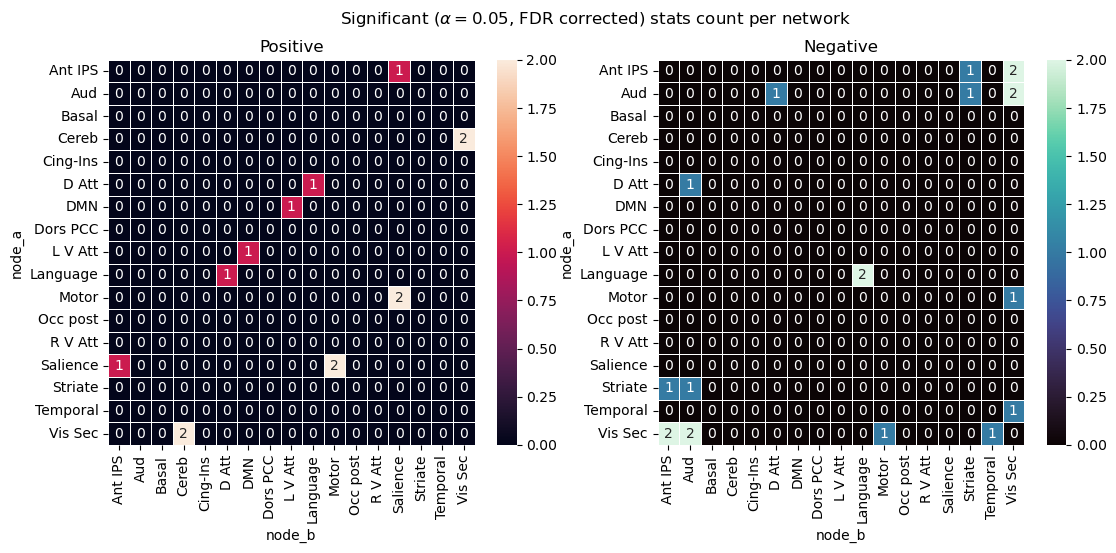

In [85]:
max_count = max(comparisons[["npos", "nneg"]].max())

heat_kwargs = {
    "xticklabels":unique_m,
    "yticklabels":unique_m,
    "vmax": max_count,
    "annot": True,
    "linewidth": 0.5
}

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(comparisons_pv.loc[:, "npos"], **heat_kwargs, cmap="rocket", ax=axes[0])
axes[0].set_title("Positive")

sns.heatmap(comparisons_pv.loc[:, "nneg"], **heat_kwargs, cmap="mako", ax=axes[1])
axes[1].set_title("Negative")
fig.suptitle(f"Significant ($\\alpha = 0.05$, FDR corrected) stats count per network")
fig.show()

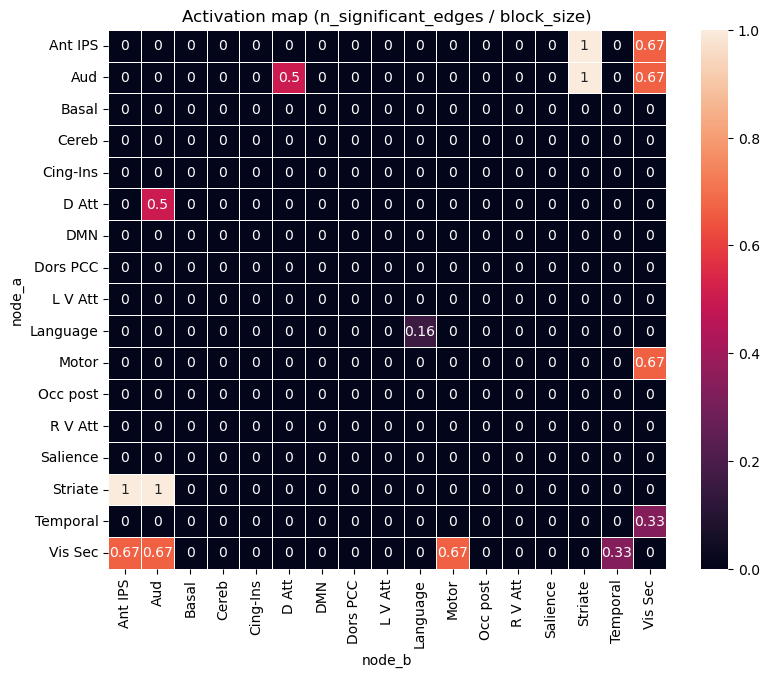

In [86]:
heat_k2 = heat_kwargs.copy()
heat_k2.pop("vmax")
plt.subplots(1, 1, figsize=(9, 7))
sns.heatmap(comparisons_pv.loc[:, "activation"], **heat_k2)
plt.title("Activation map (n_significant_edges / block_size)")
plt.show()

In [87]:
view = plotting.view_connectome(thresholded_t, coords, edge_threshold="90%")
view.open_in_browser()